### 1. Load Data and Library

#### 1.1 import library and set seed 

In [1]:
import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath(".."))
from src import (
    process_date_column,convert_bool_to_int,unique_value_summary,
    normalize_missing_strings, handle_missing_values,build_preprocessor
  )


In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

#### 1.2 Import the dataset with pandas.

In [3]:
train_df = pd.read_csv("../src/data/train.csv", encoding="utf-8")
label_df= pd.read_csv("../src/data/train_label.csv", encoding="utf-8")

# Merge datasets on 'id' column to align rows
merged = pd.merge(train_df, label_df, on="id")
print(len(train_df),len(label_df),len(merged))

59400 59400 59400


### 2. Data Processing

#### 2.1 Handle missing values.
 - 1. Normalize missing values
 - 2. Calculate and display the number of missing values per column
 - 3. Visualize the number of missing data

In [ ]:
# normalize missing values
merged = normalize_missing_strings(merged)

# Calculate and display the number of missing values per column
missing_counts = merged.isnull().sum()
dtypes = merged.dtypes

# Create a summary DataFrame
missing_summary = pd.DataFrame({
    "dtype": dtypes,
    "n_missing": missing_counts,
    "missing_pct": (missing_counts / len(merged) * 100).round(2)
}).sort_values("n_missing", ascending=False)

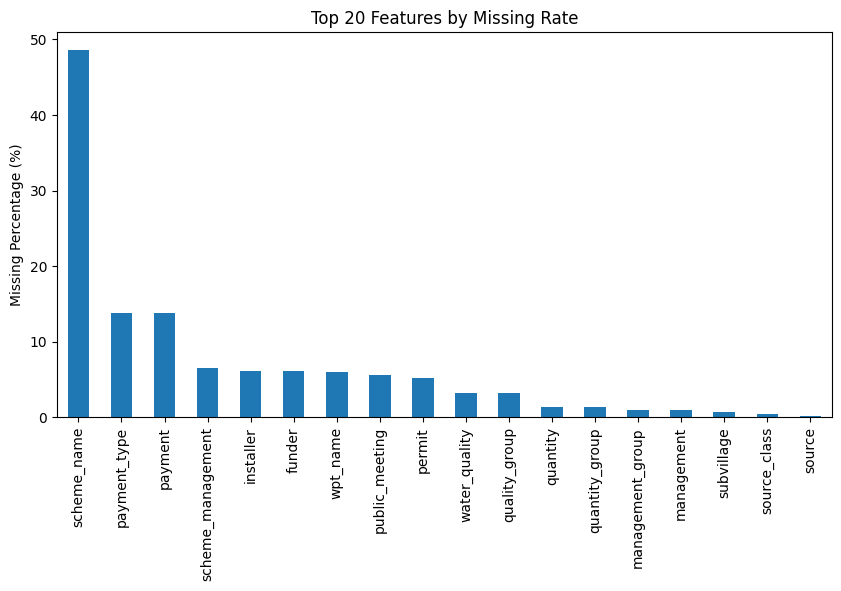

In [5]:
# visualize missing data
cols=missing_summary.index[missing_summary['n_missing'] > 0].tolist()

topN = 20
missing_summary.loc[cols, "missing_pct"].head(topN).plot(kind="bar", figsize=(10,5))
plt.ylabel("Missing Percentage (%)")
plt.title(f"Top {topN} Features by Missing Rate")
plt.show()

In [6]:
# Handle missing values
merged = handle_missing_values(merged, label_col="status_group")

# Check for remaining missing values
print(merged.isna().sum().sort_values(ascending=False))

id                           0
amount_tsh                   0
date_recorded                0
funder                       0
gps_height                   0
installer                    0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                   0
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
recorded_by                  0
scheme_management            0
scheme_name                  0
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

#### 2.2 Count unique values and prepare for encoding feature.
 - 1. Count unique values
 - 2. Visualize the number of unique data

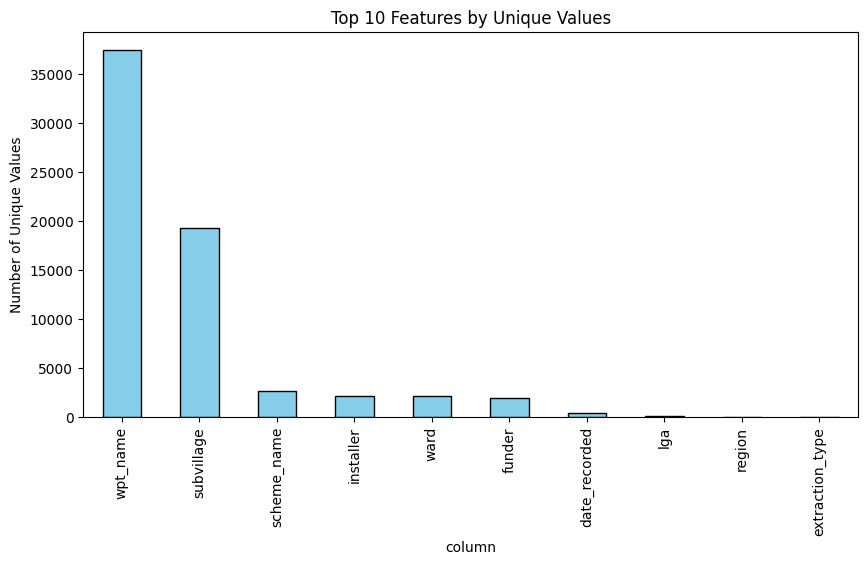

In [4]:
# count number of unique values for each column
summary = unique_value_summary(merged)
# Visualize the top N columns with the most unique values
topN = 10
summary.nlargest(topN, "nunique").set_index("column")["nunique"].plot(
    kind="bar", figsize=(10,5), color="skyblue", edgecolor="black"
)
plt.ylabel("Number of Unique Values")
plt.title(f"Top {topN} Features by Unique Values")
plt.show()

### 2.3 We created a correlation heatmap among numerical features.
- Identify redundant features.
- The guide us on feature selection: avoid keeping highly collinear features.

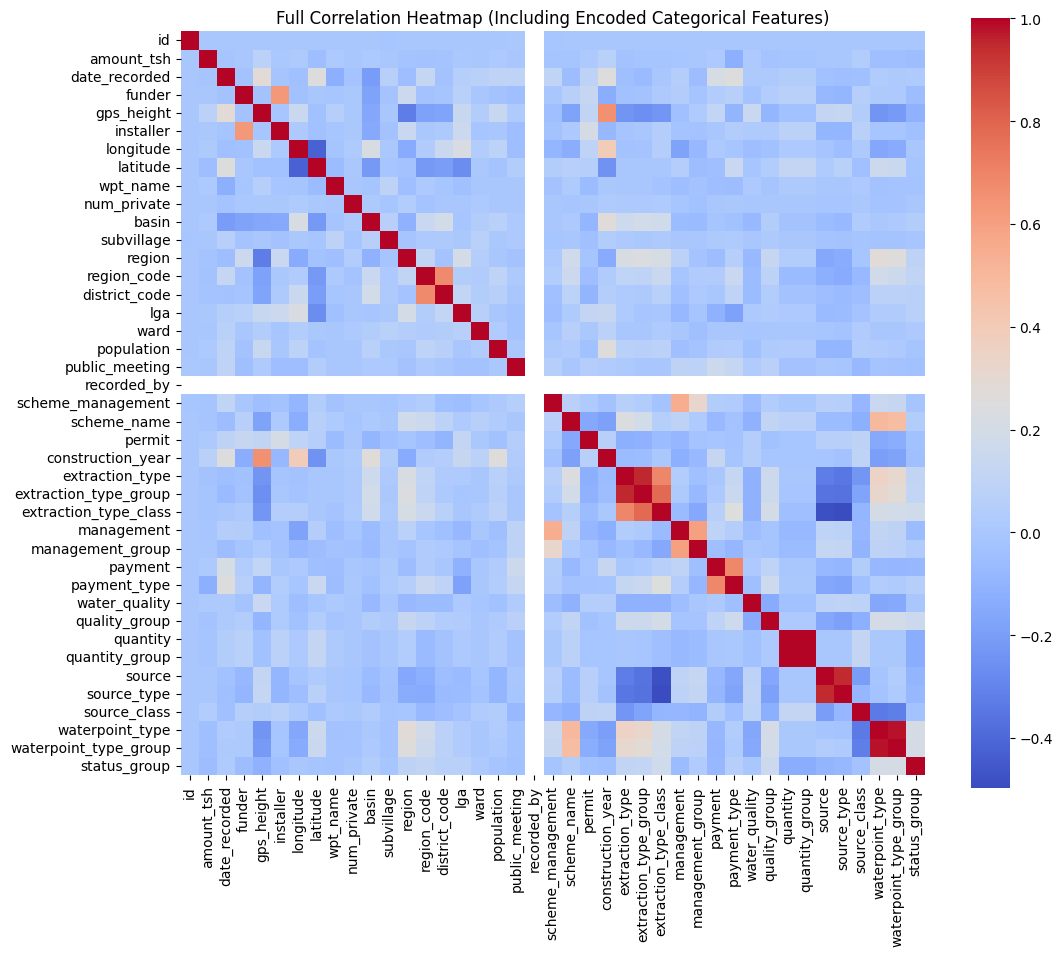

In [5]:
# Encode categorical features for correlation analysis
df_enc = merged.copy()
for col in df_enc.select_dtypes(include="object").columns:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col].astype(str))

# Compute the correlation matrix
corr = df_enc.corr()


plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", square=True)
plt.title("Full Correlation Heatmap (Including Encoded Categorical Features)")
plt.show()

### 2.4 Geographic Density Plot

- To complement the scatterplot of longitude and latitude, we also plotted a geographic density map. This shows the density “hot zones” of waterpoints by status group.

- The KDE density plot shows that waterpoints are not randomly scattered, they actually cluster in specific geographic regions. Within these regions, the distribution of functional vs. non-functional wells is not uniform. This indicates that location plays a role in waterpoint condition, and therefore geographic features can provide valuable signals to a machine learning model.

C:\Users\86182\AppData\Local\Temp\ipykernel_43508\3152283677.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


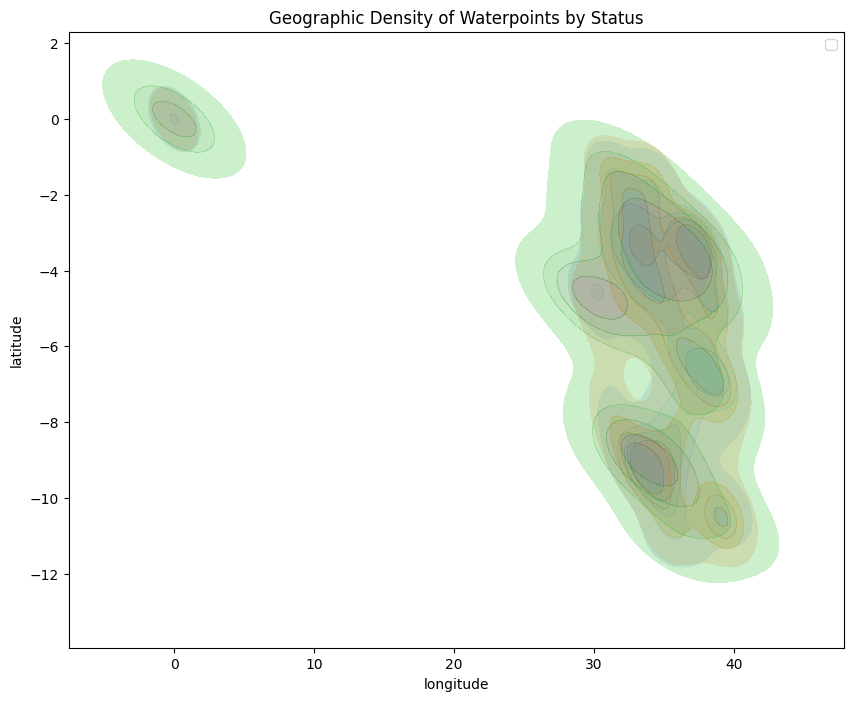

In [6]:
plt.figure(figsize=(10,8))
status_types = merged['status_group'].unique()

# Plot KDE for each status group
for status in status_types:
    subset = merged[merged['status_group'] == status]
    sns.kdeplot(
        data=subset,
        x="longitude",
        y="latitude",
        fill=True,
        alpha=0.3,
        levels=5,
        thresh=0.05,
        label=status
    )

plt.title("Geographic Density of Waterpoints by Status")
plt.legend()
plt.show()

### 3. Manual feature selection and encode date, bool and label.

#### 3.1 Manual feature selection
We drop:

- **id**: only use for matching label, no specific meaning

- **recorded_by**: it only has one value - "GeoData Consultants Ltd"

- **scheme_name**: it has nearly 50% missing values and extremely high cardinality (several thousand unique names, many occurring only once).

- **wpt_name**, **subvillage**: they have very high unique values, which are not contributed to prediction.

In [8]:
# drop columns that are useless
merged = merged.drop(columns=["id", "scheme_name"])

# drop columns that have high unique values
merged = merged.drop(columns=["wpt_name", "subvillage"])

# drop columns that need to be encoded but has too many unique values or no unique values.
merged = merged.drop(columns=["recorded_by", "num_private"])

# drop columns that contain redundant information
merged = merged.drop(
    columns=[
        "extraction_type",
        "extraction_type_group",
        "management_group",
        "payment_type",
        "quality_group",
        "quantity_group",
        "source",
        "source_class",
        "waterpoint_type_group",
    ]
)

In [9]:
print(f"Shape of merged dataframe: {merged.shape}")

Shape of merged dataframe: (59400, 27)


#### 3.2 encode date and bool type

In [10]:
# handle date column and boolean columns
merged=process_date_column(merged, 'date_recorded')
merged=convert_bool_to_int(merged)

print(f"Shape of processed dataframe: {merged.shape}")

Shape of processed dataframe: (59400, 29)


In [11]:
# save a cleaned version before one-hot encoding
output_path = "../src/data/train_cleaned.csv"
merged.to_csv(output_path, index=False)

#### 3.3 encode label

In [12]:
# handle the y label before one-hot encoding
mapping = {"non functional": 0, "functional": 1, "functional needs repair": 2}

Y = merged["status_group"]

X = merged.drop(columns=["status_group"])

Y_encoded = [mapping[val] for val in Y]
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

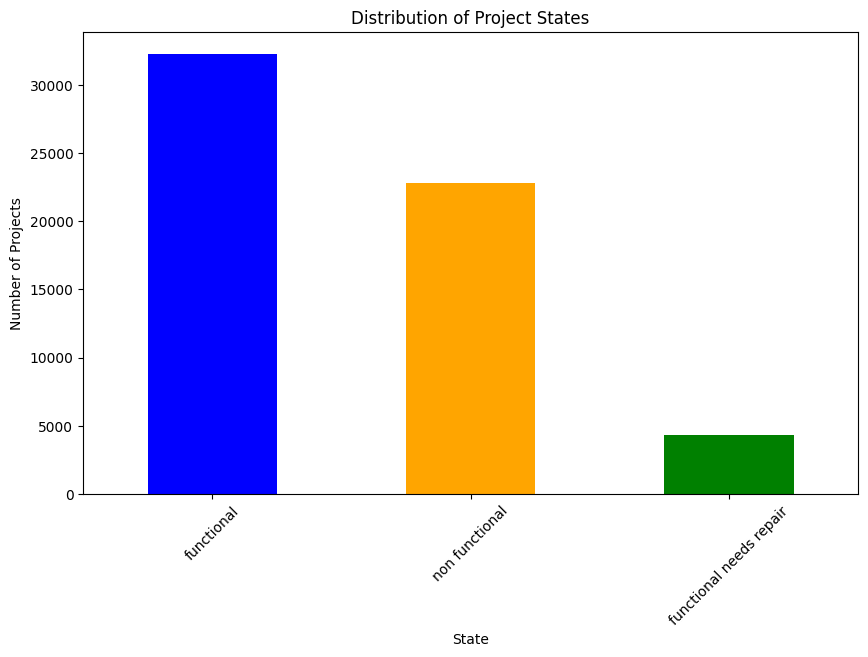

In [13]:
# visualize the distribution of the target variable
target_counts = Y.value_counts()
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Distribution of Project States')
plt.xlabel('State')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.show()

In [14]:
# check the data types of each column
print("Raw dtypes counts:\n", X.dtypes.value_counts())

Raw dtypes counts:
 object     16
int64       5
float64     4
int32       3
Name: count, dtype: int64


### 4. Model config and Training

#### 4.1 model config

In [15]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
}

param_grids = {
    "KNN": {
        "clf__n_neighbors": [3, 5, 7, 11, 15],
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2],                 # p=1 曼哈顿, p=2 欧氏
        "clf__metric": ["minkowski"],     # 与 p 配合
        "clf__algorithm": ["auto"]        # 让 sklearn 自动选择KDTree/BallTree/暴力
        # 如需更细，可加: "clf__leaf_size": [20, 30, 40]
    },
    "LogisticRegression": {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],  # 常用且与lbfgs兼容
        "clf__solver": ["lbfgs"],
        "clf__class_weight": [None, "balanced"],
    },
    "RandomForest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [ 5, 10, 20, 30, 50],
        "clf__min_samples_split": [2],
        "clf__min_samples_leaf": [1],
        "clf__max_features": ["sqrt"],
        "clf__bootstrap": [True],
    },
    "GradientBoosting": {
        "clf__n_estimators": [100, 200],
        "clf__learning_rate": [0.01, 0.1, 0.2],
        "clf__max_depth": [3, 5],
        "clf__subsample": [1.0, 0.8],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2],
        # GBDT 默认 max_features=None，一般不网格它也可
    },
}

scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro",
}

#### 4.2 Build training process

In [16]:
pre, num_cols, cat_low, cat_high = build_preprocessor(X)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_results = []
best_summaries = []

for name, clf in models.items():
    print(f"\n=== Grid Search: {name} ===")
    pipe = Pipeline([("preprocess", pre), ("fs", SelectKBest(score_func=f_classif, k=30)),("clf", clf)])

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring=scoring,
        refit="accuracy",
        cv=cv,
        n_jobs=-1,
        return_train_score=False,
        verbose=0
    )

    gs.fit(X, Y_encoded)

    cvres = pd.DataFrame(gs.cv_results_)
    keep_cols = [c for c in cvres.columns if c.startswith("param_")] + [
        "mean_test_accuracy", "std_test_accuracy",
        "mean_test_f1_macro", "std_test_f1_macro",
        "rank_test_accuracy", "rank_test_f1_macro"
    ]
    sub = cvres[keep_cols].copy().rename(columns={
        "mean_test_accuracy": "accuracy_mean",
        "std_test_accuracy": "accuracy_std",
        "mean_test_f1_macro": "f1_macro_mean",
        "std_test_f1_macro": "f1_macro_std",
    })
    sub.insert(0, "model", name)
    sub = sub.sort_values(["f1_macro_mean", "accuracy_mean"], ascending=False)

    # print top 10 results for this model
    try:
        from IPython.display import display
        print(f"\n—— {name}: descending order of f1_macro_mean、accuracy_mean (Top 10) ——")
        display(sub.head(10))
    except Exception:
        print(f"\n—— {name} results (Top 10) ——")
        print(sub.head(10))

    # —— best performance ——
    bi = gs.best_index_
    best_row = cvres.loc[bi]
    best_params = gs.best_params_
    best_summary = {
        "model": name,
        "best_params": best_params,
        "accuracy_mean": float(best_row["mean_test_accuracy"]),
        "accuracy_std": float(best_row["std_test_accuracy"]),
        "f1_macro_mean": float(best_row["mean_test_f1_macro"]),
        "f1_macro_std": float(best_row["std_test_f1_macro"]),

    }

    print(f"\n—— {name} best performance (chosen by accuracy) ——")
    print(best_summary)

    # —— summary ——
    all_results.append(sub)
    best_summaries.append(best_summary)

# —— summary ——
all_results_df = pd.concat(all_results, ignore_index=True)
print("\n========== summary: results of all models ==========")
try:
    from IPython.display import display
    display(all_results_df.head(20))
except Exception:
    print(all_results_df.head(20))

best_df = pd.DataFrame(best_summaries)
best_params_expanded = best_df["best_params"].apply(pd.Series)
best_out = pd.concat([best_df.drop(columns=["best_params"]), best_params_expanded], axis=1)
print("\n========== summary: best parameters and score of each model ==========")
try:
    from IPython.display import display
    display(best_out)
except Exception:
    print(best_out)



=== Grid Search: LogisticRegression ===

—— LogisticRegression: descending order of f1_macro_mean、accuracy_mean (Top 10) ——


,model,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__solver,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std,rank_test_accuracy,rank_test_f1_macro
7,LogisticRegression,10.00,balanced,l2,lbfgs,0.610640,0.008035,0.536365,0.005276,5,1
5,LogisticRegression,1.00,balanced,l2,lbfgs,0.610387,0.008083,0.536228,0.005455,6,2
3,LogisticRegression,0.10,balanced,l2,lbfgs,0.608485,0.007229,0.534908,0.004671,7,3
1,LogisticRegression,0.01,balanced,l2,lbfgs,0.607879,0.007633,0.534397,0.005271,8,4
6,LogisticRegression,10.00,None,l2,lbfgs,0.721818,0.004697,0.513352,0.007256,1,5
4,LogisticRegression,1.00,None,l2,lbfgs,0.721734,0.004684,0.513047,0.007343,2,6
2,LogisticRegression,0.10,None,l2,lbfgs,0.721330,0.004822,0.509422,0.008980,3,7
0,LogisticRegression,0.01,None,l2,lbfgs,0.718990,0.003780,0.495019,0.004989,4,8



—— LogisticRegression best performance (chosen by accuracy) ——
{'model': 'LogisticRegression', 'best_params': {'clf__C': 10, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}, 'accuracy_mean': 0.7218181818181818, 'accuracy_std': 0.0046967585002540314, 'f1_macro_mean': 0.513352313077359, 'f1_macro_std': 0.007256129117411386}

=== Grid Search: RandomForest ===

—— RandomForest: descending order of f1_macro_mean、accuracy_mean (Top 10) ——


,model,param_clf__bootstrap,param_clf__max_depth,param_clf__max_features,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std,rank_test_accuracy,rank_test_f1_macro
6,RandomForest,True,30,sqrt,1,2,100,0.779024,0.004154,0.661396,0.004241,3,1
7,RandomForest,True,30,sqrt,1,2,200,0.778754,0.003774,0.660976,0.003716,4,2
5,RandomForest,True,20,sqrt,1,2,200,0.793165,0.002464,0.660585,0.004970,1,3
4,RandomForest,True,20,sqrt,1,2,100,0.792879,0.003088,0.660389,0.003775,2,4
9,RandomForest,True,50,sqrt,1,2,200,0.775859,0.004562,0.659272,0.005277,5,5
8,RandomForest,True,50,sqrt,1,2,100,0.775606,0.004156,0.658564,0.004708,6,6
3,RandomForest,True,10,sqrt,1,2,200,0.751633,0.003962,0.550976,0.004059,7,7
2,RandomForest,True,10,sqrt,1,2,100,0.751279,0.003821,0.550552,0.003350,8,8
0,RandomForest,True,5,sqrt,1,2,100,0.717694,0.005288,0.477988,0.004572,9,9
1,RandomForest,True,5,sqrt,1,2,200,0.716380,0.004607,0.476561,0.004037,10,10



—— RandomForest best performance (chosen by accuracy) ——
{'model': 'RandomForest', 'best_params': {'clf__bootstrap': True, 'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}, 'accuracy_mean': 0.7931649831649832, 'accuracy_std': 0.002463556087114969, 'f1_macro_mean': 0.6605853843168974, 'f1_macro_std': 0.004969813451796252}

=== Grid Search: GradientBoosting ===

—— GradientBoosting: descending order of f1_macro_mean、accuracy_mean (Top 10) ——


,model,param_clf__learning_rate,param_clf__max_depth,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,param_clf__subsample,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std,rank_test_accuracy,rank_test_f1_macro
86,GradientBoosting,0.2,5,1,5,200,1.0,0.781599,0.003669,0.644925,0.008021,7,1
83,GradientBoosting,0.2,5,1,2,200,0.8,0.782054,0.002823,0.644831,0.005564,5,2
94,GradientBoosting,0.2,5,2,5,200,1.0,0.782828,0.004046,0.644632,0.004866,1,3
87,GradientBoosting,0.2,5,1,5,200,0.8,0.782559,0.002723,0.644478,0.004629,3,4
91,GradientBoosting,0.2,5,2,2,200,0.8,0.781448,0.003388,0.644446,0.003588,8,5
90,GradientBoosting,0.2,5,2,2,200,1.0,0.782609,0.001931,0.644260,0.005380,2,6
95,GradientBoosting,0.2,5,2,5,200,0.8,0.782357,0.002688,0.644059,0.006329,4,7
82,GradientBoosting,0.2,5,1,2,200,1.0,0.781616,0.003611,0.642477,0.007963,6,8
88,GradientBoosting,0.2,5,2,2,100,1.0,0.775589,0.003410,0.632158,0.007961,23,9
84,GradientBoosting,0.2,5,1,5,100,1.0,0.776077,0.004043,0.632135,0.006822,19,10



—— GradientBoosting best performance (chosen by accuracy) ——
{'model': 'GradientBoosting', 'best_params': {'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'clf__subsample': 1.0}, 'accuracy_mean': 0.7828282828282829, 'accuracy_std': 0.004046011821090864, 'f1_macro_mean': 0.6446321493492537, 'f1_macro_std': 0.004865903580832324}

=== Grid Search: KNN ===


d:\MyApplication\Anaconda\envs\ml_lab1\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.76367003 0.7583165  0.76457912        nan 0.77094276 0.76762626
        nan        nan 0.77284512 0.77170034        nan        nan
 0.77069024 0.77454545        nan        nan 0.76754209 0.77631313
        nan        nan]
  warnings.warn(
d:\MyApplication\Anaconda\envs\ml_lab1\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.64565013 0.64636929 0.64622062        nan 0.64747238 0.65583883
        nan        nan 0.64838936 0.66003385        nan        nan
 0.63925072 0.66097076        nan        nan 0.62995783 0.6614829
        nan 0.65939399]
  warnings.warn(



—— KNN: descending order of f1_macro_mean、accuracy_mean (Top 10) ——


,model,param_clf__algorithm,param_clf__metric,param_clf__n_neighbors,param_clf__p,param_clf__weights,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std,rank_test_accuracy,rank_test_f1_macro
17,KNN,auto,minkowski,15,1,distance,0.776313,0.004718,0.661483,0.004638,1,1
13,KNN,auto,minkowski,11,1,distance,0.774545,0.004545,0.660971,0.004856,2,2
9,KNN,auto,minkowski,7,1,distance,0.771700,0.004860,0.660034,0.004448,4,3
19,KNN,auto,minkowski,15,2,distance,NaN,NaN,0.659394,0.003673,12,4
5,KNN,auto,minkowski,5,1,distance,0.767626,0.005012,0.655839,0.004837,7,5
8,KNN,auto,minkowski,7,1,uniform,0.772845,0.002995,0.648389,0.004303,3,6
4,KNN,auto,minkowski,5,1,uniform,0.770943,0.004403,0.647472,0.004655,5,7
1,KNN,auto,minkowski,3,1,distance,0.758316,0.004303,0.646369,0.003057,11,8
2,KNN,auto,minkowski,3,2,uniform,0.764579,0.003045,0.646221,0.004713,9,9
0,KNN,auto,minkowski,3,1,uniform,0.763670,0.002513,0.645650,0.001785,10,10



—— KNN best performance (chosen by accuracy) ——
{'model': 'KNN', 'best_params': {'clf__algorithm': 'auto', 'clf__metric': 'minkowski', 'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'distance'}, 'accuracy_mean': 0.7763131313131314, 'accuracy_std': 0.004717591071898746, 'f1_macro_mean': 0.661482899308711, 'f1_macro_std': 0.0046381928428264625}

========== summary: results of all models ==========


,model,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__solver,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std,rank_test_accuracy,...,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,param_clf__learning_rate,param_clf__subsample,param_clf__algorithm,param_clf__metric,param_clf__n_neighbors,param_clf__p,param_clf__weights
0,LogisticRegression,10.00,balanced,l2,lbfgs,0.610640,0.008035,0.536365,0.005276,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LogisticRegression,1.00,balanced,l2,lbfgs,0.610387,0.008083,0.536228,0.005455,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LogisticRegression,0.10,balanced,l2,lbfgs,0.608485,0.007229,0.534908,0.004671,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LogisticRegression,0.01,balanced,l2,lbfgs,0.607879,0.007633,0.534397,0.005271,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LogisticRegression,10.00,None,l2,lbfgs,0.721818,0.004697,0.513352,0.007256,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LogisticRegression,1.00,None,l2,lbfgs,0.721734,0.004684,0.513047,0.007343,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,LogisticRegression,0.10,None,l2,lbfgs,0.721330,0.004822,0.509422,0.008980,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LogisticRegression,0.01,None,l2,lbfgs,0.718990,0.003780,0.495019,0.004989,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,RandomForest,NaN,NaN,NaN,NaN,0.779024,0.004154,0.661396,0.004241,3,...,1.0,2.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,RandomForest,NaN,NaN,NaN,NaN,0.778754,0.003774,0.660976,0.003716,4,...,1.0,2.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



========== summary: best parameters and score of each model ==========


,model,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std,clf__C,clf__class_weight,clf__penalty,clf__solver,clf__bootstrap,...,clf__min_samples_leaf,clf__min_samples_split,clf__n_estimators,clf__learning_rate,clf__subsample,clf__algorithm,clf__metric,clf__n_neighbors,clf__p,clf__weights
0,LogisticRegression,0.721818,0.004697,0.513352,0.007256,10.0,NaN,l2,lbfgs,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RandomForest,0.793165,0.002464,0.660585,0.004970,NaN,NaN,NaN,NaN,True,...,1.0,2.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GradientBoosting,0.782828,0.004046,0.644632,0.004866,NaN,NaN,NaN,NaN,NaN,...,2.0,5.0,200.0,0.2,1.0,NaN,NaN,NaN,NaN,NaN
3,KNN,0.776313,0.004718,0.661483,0.004638,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,auto,minkowski,15.0,1.0,distance
